In [ ]:
!pip install segmentation_models_pytorch
!wget https://raw.githubusercontent.com/johschmidt42/PyTorch-2D-3D-UNet-Tutorial/master/trainer.py

In [2]:
! git clone https://github.com/HSE-LAMBDA/RheologyReconstruction.git

Cloning into 'RheologyReconstruction'...
remote: Enumerating objects: 461, done.
remote: Counting objects: 100% (461/461), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 461 (delta 218), reused 323 (delta 135), pack-reused 0
Receiving objects: 100% (461/461), 19.30 MiB | 18.50 MiB/s, done.
Resolving deltas: 100% (218/218), done.


In [ ]:
! pip install dvc
! pip install 'dvc[azure]'

In [ ]:
!cd RheologyReconstruction/datasets/ && dvc pull heterogeneity.tar.xz.dvc

In [ ]:
!cd RheologyReconstruction/datasets/ && tar -xvf heterogeneity.tar.xz

In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from trainer import Trainer

In [3]:
from typing import Optional, Union, List
from segmentation_models_pytorch.unet.decoder import UnetDecoder
from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import SegmentationModel
from segmentation_models_pytorch.base import SegmentationHead, ClassificationHead

import torch
import torch.nn as nn
import torch.nn.functional as F

from segmentation_models_pytorch.base import modules as md

In [4]:
class CenterBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        conv1 = md.Conv2dReLU(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        super().__init__(conv1, conv2)

In [5]:
class MyDecoderBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            #skip_channels,
            out_channels,
            use_batchnorm=True,
            attention_type=None,
    ):
        super().__init__()
        #print(skip_channels)
        self.conv1 = md.Conv2dReLU(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention1 = md.Attention(attention_type, in_channels=in_channels)
        self.conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention2 = md.Attention(attention_type, in_channels=out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x

In [6]:
class MyUnetDecoder(nn.Module):
    def __init__(
            self,
            encoder_channels,
            decoder_channels,
            n_blocks=5,
            use_batchnorm=True,
            attention_type=None,
            center=False,
    ):
        super().__init__()

        if n_blocks != len(decoder_channels):
            raise ValueError(
                "Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)
                )
            )

        encoder_channels = encoder_channels[1:]  # remove first skip with same spatial resolution
        encoder_channels = encoder_channels[::-1]  # reverse channels to start from head of encoder

        # computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        #skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels

        if center:
            self.center = CenterBlock(
                head_channels, head_channels, use_batchnorm=use_batchnorm
            )
        else:
            self.center = nn.Identity()

        # combine decoder keyword arguments
        kwargs = dict(use_batchnorm=use_batchnorm, attention_type=attention_type)
        blocks = [
            MyDecoderBlock(in_ch, out_ch, **kwargs)
            for in_ch, out_ch in zip(in_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):

        features = features[1:]    # remove first skip with same spatial resolution
        features = features[::-1]  # reverse channels to start from head of encoder

        head = features[0]
        skips = features[1:]

        x = self.center(head)
        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)

        return x

In [7]:
class MyUnet(SegmentationModel):

    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_depth: int = 5,
        encoder_weights: Optional[str] = "imagenet",
        decoder_use_batchnorm: bool = True,
        decoder_channels: List[int] = (256, 128, 64, 32, 16),
        decoder_attention_type: Optional[str] = None,
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, callable]] = None,
        aux_params: Optional[dict] = None,
    ):
        super().__init__()

        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
        )

        self.decoder = MyUnetDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            center=True if encoder_name.startswith("vgg") else False,
            attention_type=decoder_attention_type,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=classes,
            activation=activation,
            kernel_size=3,
        )

        if aux_params is not None:
            self.classification_head = ClassificationHead(
                in_channels=self.encoder.out_channels[-1], **aux_params
            )
        else:
            self.classification_head = None

        self.name = "u-{}".format(encoder_name)
        self.initialize()

In [60]:
def IOU_loss(output, target):
  proba = torch.nn.Softmax()(output)[:,1]
  pred = proba >= 0.5
  #print(output.shape, proba.shape, pred.shape, target.shape)
  loss = torch.sum(pred * target) / torch.sum((pred + target) > 0) #torch.mean((output - target)**2)
  return loss 

In [8]:
from numpy.fft import fft2, fftshift, ifftshift

def transform_seismogram(seismogram):
  seismogram_transformed = []
  for i in range(2):
      transformed = fftshift(fft2(ifftshift(seismogram[i])))
      seismogram_transformed.append(transformed.real)
      seismogram_transformed.append(transformed.imag)
  return np.array(seismogram_transformed)
#seismograms_transformed = np.array([transform_seismogram(seismogram) for seismogram in seismograms])
#seismograms_transformed.shape

In [9]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torch
from torch import nn

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
import os
from numpy.fft import fft2, fftshift, ifftshift
from torch.utils.data import Dataset
import re

class SeismogramDataset(Dataset):
    """
    Seismogram dataset.
    Implements the interface of torch.utils.dataset.Dataset
    Names of the files must contain numerals, due to the indexing issues
    File with the least numeral is considered to be a 'head' of the dataset
    
    """

    def __init__(self, root_dir, ellipsis, do_transform=True):
        """
        :param root_dir (string): 
            A root directory of the dataset. Following layout is assumed:
                /root
                    /seismograms
                    /masks
        :param scaling_factor (float):
            Constant multiplier for seismograms. Default=1e7
            
        """
        self.root_dir    = os.path.join(os.getcwd(), root_dir)
        self.data_dir    = os.path.join(self.root_dir, 'seismograms')
        self.mesh_dir    = os.path.join(self.root_dir, 'masks')

        self.seismograms = [(file, re.findall(r'(\d+)', file)[-1]) for file in os.listdir(self.data_dir)]
        self.seismograms = [x[0] for x in list(sorted(self.seismograms, key= lambda x: x[1]))][ellipsis[0]:ellipsis[1]]
        
        self.masks = [(file, re.findall(r'(\d+)', file)[-1]) for file in os.listdir(self.mesh_dir)]
        self.masks = [x[0] for x in list(sorted(self.masks, key= lambda x: x[1]))][ellipsis[0]:ellipsis[1]]
        self.do_transform = do_transform

    def __len__(self):
        return len(self.seismograms)

    def __getitem__(self, idx):

        sname = os.path.join(self.data_dir, self.seismograms[idx])
        mname = os.path.join(self.mesh_dir, self.masks[idx])

        s = None
        if not self.do_transform:
          s = torch.from_numpy(np.load(sname)).float()
        else:
          s = torch.from_numpy(transform_seismogram(np.load(sname))).float()

        m = torch.from_numpy(np.load(mname)).long()

        return s, m

Пробуем обучить автоэнкодер

In [12]:
class AutoencodeDataset(Dataset):
    """
    Seismogram dataset.
    Implements the interface of torch.utils.dataset.Dataset
    Names of the files must contain numerals, due to the indexing issues
    File with the least numeral is considered to be a 'head' of the dataset
    
    """

    def __init__(self, root_dir, ellipsis):
        """
        :param root_dir (string): 
            A root directory of the dataset. Following layout is assumed:
                /root
                    /seismograms
                    /masks
        :param scaling_factor (float):
            Constant multiplier for seismograms. Default=1e7
            
        """
        self.root_dir    = os.path.join(os.getcwd(), root_dir)
        self.data_dir    = os.path.join(self.root_dir, 'seismograms')
        self.mesh_dir    = os.path.join(self.root_dir, 'masks')

        self.seismograms = [(file, re.findall(r'(\d+)', file)[-1]) for file in os.listdir(self.data_dir)]
        self.seismograms = [x[0] for x in list(sorted(self.seismograms, key= lambda x: x[1]))][ellipsis[0]:ellipsis[1]]
        
        self.masks = [(file, re.findall(r'(\d+)', file)[-1]) for file in os.listdir(self.mesh_dir)]
        self.masks = [x[0] for x in list(sorted(self.masks, key= lambda x: x[1]))][ellipsis[0]:ellipsis[1]]

    def __len__(self):
        return len(self.seismograms)

    def __getitem__(self, idx):

        sname = os.path.join(self.data_dir, self.seismograms[idx])
        s = torch.from_numpy(np.load(sname)).float()

        return s, s.ravel()

In [13]:
ae_bath_size = 10
a_training_dataset = AutoencodeDataset('RheologyReconstruction/datasets/heterogeneity/',(0, 4000))
a_training_dataloader = torch.utils.data.DataLoader(
    dataset=a_training_dataset, batch_size=ae_bath_size, shuffle=True)
a_val_dataset = AutoencodeDataset('RheologyReconstruction/datasets/heterogeneity/',(4000, 4500))
a_val_dataloader = torch.utils.data.DataLoader(
    dataset=a_val_dataset, batch_size=ae_bath_size, shuffle=True)
a_test_dataset = AutoencodeDataset('RheologyReconstruction/datasets/heterogeneity/',(4500, 5000))
a_test_dataloader = torch.utils.data.DataLoader(
    dataset=a_test_dataset, batch_size=ae_bath_size, shuffle=True)

In [14]:
ae_model = nn.Sequential(MyUnet(
      encoder_name="resnet18",  
      encoder_depth = 5,
      in_channels=2,      
      classes=2,
  ),
  torch.nn.Flatten()
)

if torch.cuda.is_available():
    ae_model.cuda()

In [15]:
loss = [torch.nn.MSELoss(), torch.nn.L1Loss()][1]
ae_criterion = loss #
ae_optimizer = torch.optim.Adam(ae_model.parameters(), lr=1e-4)
ae_loss_fn = loss # torch.nn.L1Loss()

In [115]:
ae_trainer = Trainer(model=ae_model,
                  device=device,
                  criterion=ae_criterion,
                  optimizer=ae_optimizer,
                  training_DataLoader=a_training_dataloader,
                  validation_DataLoader=a_val_dataloader,
                  lr_scheduler=None,
                  epochs=100,
                  epoch=30,
                  notebook=True)

In [116]:
ae_batch = next(iter(a_training_dataloader))
ae_batch[0].shape, ae_batch[1].shape

(torch.Size([10, 2, 128, 128]), torch.Size([10, 32768]))

In [117]:
ae_model(ae_batch[0].cuda()).shape

torch.Size([10, 32768])

In [118]:
ae_history = ae_trainer.run_trainer()

Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

In [119]:
ae_batch = next(iter(a_test_dataloader))

s = 128
pred = ae_model(ae_batch[0].cuda()).cpu().detach().numpy().reshape((len(ae_batch[0]), 2, s, s))
gt = ae_batch[1].detach().numpy().reshape((len(ae_batch[0]), 2, s, s))

pred.shape, gt.shape

((10, 2, 128, 128), (10, 2, 128, 128))

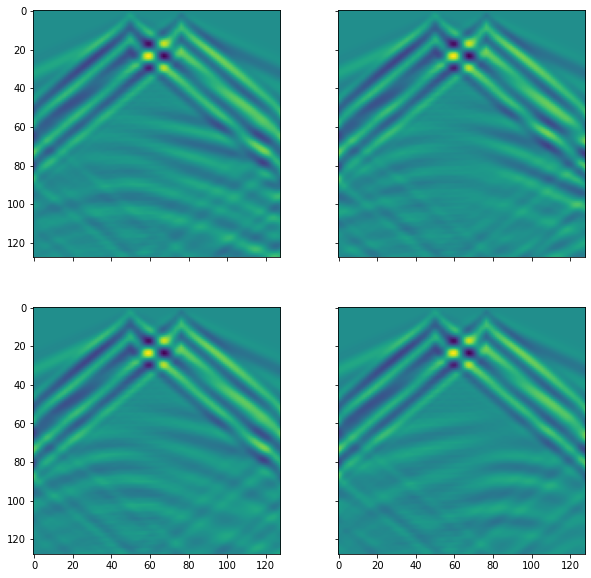

In [120]:
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10, 10))
for i in range(4):
    ax[i // 2][i % 2].imshow(gt[i, 0]) 

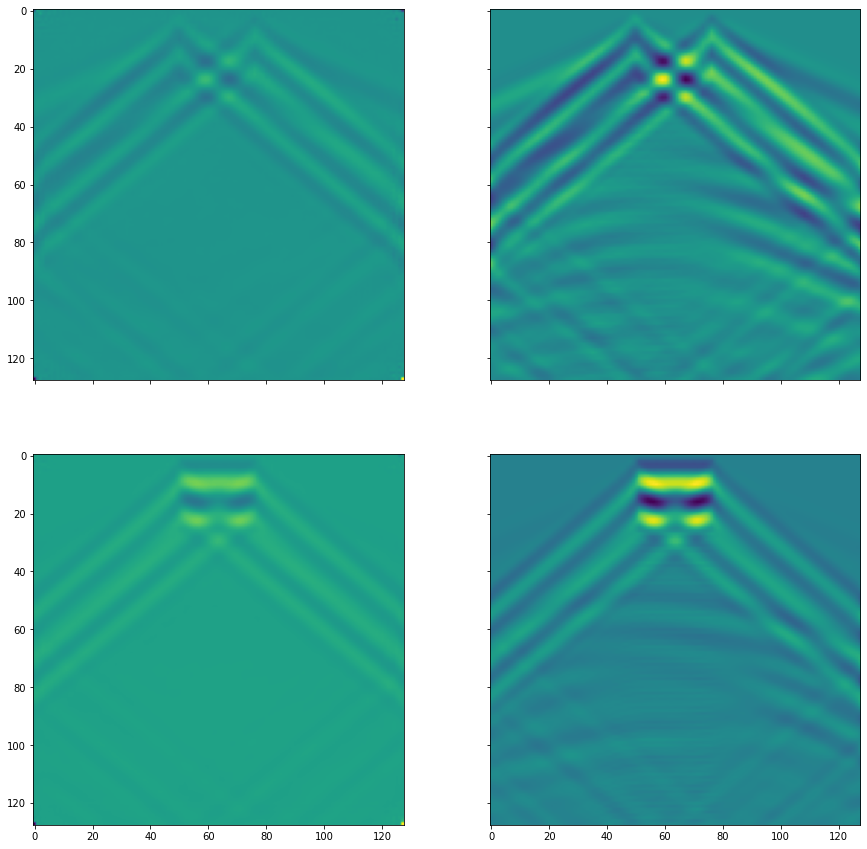

In [121]:
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(15, 15))
fig.patch.set_visible(False)

j = 1
pred_, gt_ = pred[j], gt[j]
for i in range(2):
  ax[i][0].imshow(pred_[i]) 
  ax[i][1].imshow(gt_[i])

In [122]:
torch.save(ae_model, "/content/drive/MyDrive/saved_ml_models/autoencoder_no_Fourrier")

In [123]:
#model2

In [124]:
model2 = list(ae_model.children())[0]

In [125]:
bath_size = 10
do_transform = False
training_dataset = SeismogramDataset('RheologyReconstruction/datasets/heterogeneity/',(0, 4000), do_transform=do_transform)
training_dataloader = torch.utils.data.DataLoader(
    dataset=training_dataset, batch_size=bath_size, shuffle=True)
val_dataset = SeismogramDataset('RheologyReconstruction/datasets/heterogeneity/',(4000, 4500), do_transform=do_transform)
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=bath_size, shuffle=True)
test_dataset = SeismogramDataset('RheologyReconstruction/datasets/heterogeneity/',(4500, 5000), do_transform=do_transform)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=500, shuffle=False)

In [135]:
m2 = torch.load("/content/drive/MyDrive/saved_ml_models/autoencoder_no_Fourrier")

In [ ]:
encoder = list(list(m2.children())[0].children())[0]
encoder

In [137]:
freeze = True
if freeze:
  for param in encoder.parameters():
      param.requires_grad = False

In [133]:
#model

In [140]:
model = list(m2.children())[0]
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
trainer = MyTrainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=training_dataloader,
                  validation_DataLoader=val_dataloader,
                  lr_scheduler=None,
                  epochs=10,
                  epoch=0,
                  notebook=True)
history = trainer.run_trainer()

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
plt.plot(history['val_IOU'])

Объединяем модели, обученные на обоих типах данных

In [16]:
class TwoInputSeismogramDataset(Dataset):

    def __init__(self, root_dir, ellipsis, do_transform=True):
        self.root_dir    = os.path.join(os.getcwd(), root_dir)
        self.data_dir    = os.path.join(self.root_dir, 'seismograms')
        self.mesh_dir    = os.path.join(self.root_dir, 'masks')

        self.seismograms = [(file, re.findall(r'(\d+)', file)[-1]) for file in os.listdir(self.data_dir)]
        self.seismograms = [x[0] for x in list(sorted(self.seismograms, key= lambda x: x[1]))][ellipsis[0]:ellipsis[1]]
        
        self.masks = [(file, re.findall(r'(\d+)', file)[-1]) for file in os.listdir(self.mesh_dir)]
        self.masks = [x[0] for x in list(sorted(self.masks, key= lambda x: x[1]))][ellipsis[0]:ellipsis[1]]
        self.do_transform = do_transform

    def __len__(self):
        return len(self.seismograms)

    def __getitem__(self, idx):

        sname = os.path.join(self.data_dir, self.seismograms[idx])
        mname = os.path.join(self.mesh_dir, self.masks[idx])

        s1 = torch.from_numpy(np.load(sname)).float()
        s2 = torch.from_numpy(transform_seismogram(np.load(sname))).float()

        m = torch.from_numpy(np.load(mname)).long()

        return s1, s2, m

In [17]:
bath_size = 10
do_transform = False
training_dataset = TwoInputSeismogramDataset('RheologyReconstruction/datasets/heterogeneity/',(0, 4000), do_transform=do_transform)
training_dataloader = torch.utils.data.DataLoader(
    dataset=training_dataset, batch_size=bath_size, shuffle=True)
val_dataset = TwoInputSeismogramDataset('RheologyReconstruction/datasets/heterogeneity/',(4000, 4500), do_transform=do_transform)
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=bath_size, shuffle=True)
test_dataset = TwoInputSeismogramDataset('RheologyReconstruction/datasets/heterogeneity/',(4500, 5000), do_transform=do_transform)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=500, shuffle=False)

In [26]:
sample = next(iter(training_dataloader))
s1, s2, m = sample
s1, s2 = s1.cuda(), s2.cuda()
s1.shape, s2.shape, m.shape

(torch.Size([10, 2, 128, 128]),
 torch.Size([10, 4, 128, 128]),
 torch.Size([10, 128, 128]))

In [53]:
class ResUniter(nn.Module):
    def __init__(
            self,
    ):
        super().__init__()
        self.model1 = MyUnet(
              encoder_name="resnet18",  
              encoder_depth = 5,
              in_channels=2,      
              classes=2,
        )
        self.model2 = MyUnet(
              encoder_name="resnet18",  
              encoder_depth = 5,
              in_channels=4,      
              classes=2,
        )
        self.convolution = nn.Conv2d(4, 2, 3, stride=1, padding=2, dilation=2, padding_mode='zeros')

    def forward(self, s1, s2, skip=None):
      r1 = self.model1(s1)
      r2 = self.model2(s2)
      a = self.convolution(torch.cat((r1, r2), dim=1))
      return a

res_uniter = ResUniter().cuda()

In [54]:
res_uniter(s1, s2).shape

torch.Size([10, 2, 128, 128])

In [61]:
class DoubleInputMyTrainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook

        self.training_loss = []
        self.validation_loss = []

        self.validation_IOU = []

        self.learning_rate = []

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.batch()  # learning rate scheduler step
        return {
              'train_loss': self.training_loss, 
              'val_loss': self.validation_loss,
              'lr': self.learning_rate,
              'val_IOU': self.validation_IOU
        }

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, (x1, x2, y) in batch_iter:
            input1, input2, target = x1.to(self.device), x2.to(self.device), y.to(self.device) 
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input1, input2)  # one forward pass
            loss = self.criterion(out, target)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        IOU_losses = []

        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, (x1, x2, y) in batch_iter:
            input1, input2, target = x1.to(self.device), x2.to(self.device), y.to(self.device) 

            with torch.no_grad():
                out = self.model(input1, input2)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                IOU_value = IOU_loss(out, target).item()



                valid_losses.append(loss_value)
                IOU_losses.append(IOU_value)

                #batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')
                batch_iter.set_description(f'Validation: (IOU {IOU_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))
        self.validation_IOU.append(np.mean(IOU_losses))


        batch_iter.close()

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res_uniter.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
trainer = DoubleInputMyTrainer(model=res_uniter,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=training_dataloader,
                  validation_DataLoader=val_dataloader,
                  lr_scheduler=None,
                  epochs=100,
                  epoch=0,
                  notebook=True)
history = trainer.run_trainer()

In [ ]:
plt.plot(history['val_IOU'])

In [7]:
class MyTrainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook

        self.training_loss = []
        self.validation_loss = []

        self.validation_IOU = []

        self.learning_rate = []

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.batch()  # learning rate scheduler step
        return {
              'train_loss': self.training_loss, 
              'val_loss': self.validation_loss,
              'lr': self.learning_rate,
              'val_IOU': self.validation_IOU
        }

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass
            loss = self.criterion(out, target)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        IOU_losses = []

        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                IOU_value = IOU_loss(out, target).item()



                valid_losses.append(loss_value)
                IOU_losses.append(IOU_value)

                #batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')
                batch_iter.set_description(f'Validation: (IOU {IOU_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))
        self.validation_IOU.append(np.mean(IOU_losses))


        batch_iter.close()

In [144]:
in_channels = next(iter(training_dataloader))[0].shape[1]
in_channels

2

In [10]:
model = nn.Sequential(
    smp.UnetPlusPlus(
        encoder_name="resnet18",  
        in_channels=in_channels,      
        classes=2,
    ),
)

In [11]:
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()
trainer = MyTrainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=training_dataloader,
                  validation_DataLoader=val_dataloader,
                  lr_scheduler=None,
                  epochs=120,
                  epoch=0,
                  notebook=True)
history = trainer.run_trainer()

Progress:   0%|          | 0/120 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Validation:   0%|          | 0/50 [00:00<?, ?it/s]

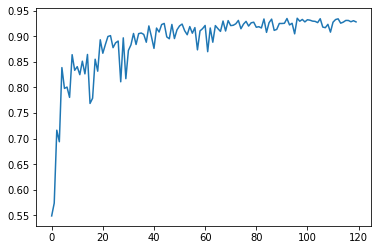

In [139]:
plt.plot(history['val_IOU'])

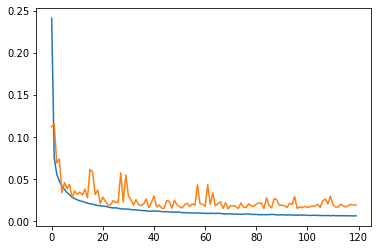

In [96]:
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])

In [97]:
history['val_IOU'][-1]

0.928128092288971

In [98]:
history['val_loss'][-1]

0.019153203759342433

Рисуем результаты

In [87]:
#next(iter(test_dataloader))

In [19]:
batch = [x[:10] for x in next(iter(test_dataloader))]

proba = torch.nn.Softmax()(model(batch[0].cuda())).cpu().detach().numpy()[:,1]
proba.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


(10, 128, 128)

In [20]:
ground = batch[1].cpu().numpy()

In [21]:
pred = proba >= 0.5
print(f"Test accuracy: {np.mean(pred == ground )}")

Test accuracy: 0.993743896484375


In [22]:
CE = torch.nn.CrossEntropyLoss()(model(batch[0][:200].cuda()), batch[1][:200].cuda())
print(f"Tesr CE: {CE.item()}")

Tesr CE: 0.03338179737329483


In [23]:
IOU = np.sum(pred * ground) / np.sum((pred + ground) > 0)
print(f"Test IOU: {IOU}")

Test IOU: 0.926290809722422


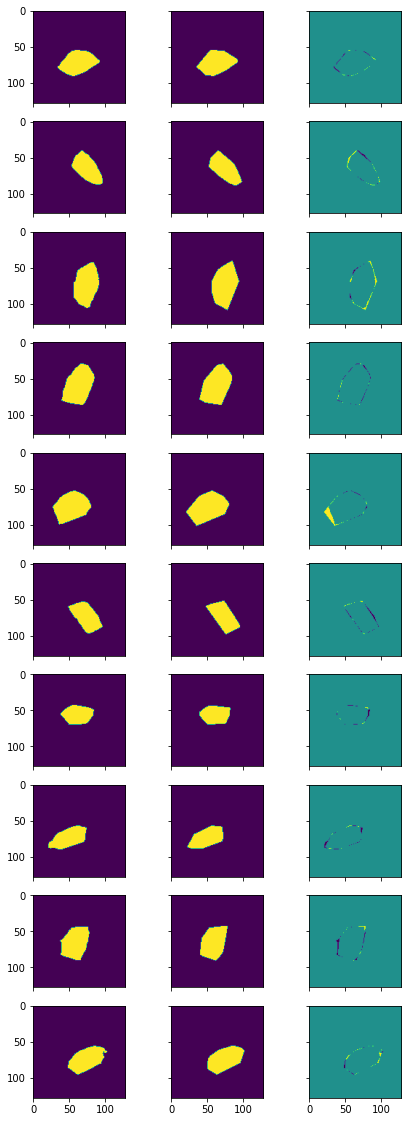

In [24]:
fig, ax = plt.subplots(10, 3, sharey=True, sharex=True, figsize=(7, 20))
fig.patch.set_visible(False)

for i, (pr, gt) in enumerate(zip(pred[:10], ground)):
  ax[i][0].imshow(pr) #.shape
  ax[i][1].imshow(gt)
  ax[i][2].imshow(gt - pr)

|Name |Accuracy|IOU|
|-----|--------|---|
|With Fourier transform|0.97      | 0.63|
|Without Fourier transform|0.98      |0.7|

In [67]:
!mkdir /content/drive/MyDrive/saved_ml_models

In [93]:
!mkdir /content/drive/MyDrive/saved_train_results

In [26]:
torch.save(model, "/content/drive/MyDrive/saved_ml_models/UNet++")

In [27]:
with open("/content/drive/MyDrive/saved_train_results/UNet++.pckl", "wb") as f:
  pickle.dump(history, f)